Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 151MB/s]


Epoch 1/50: Train Loss: 1.0622, Train Acc: 0.6073, Val Loss: 0.7824, Val Acc: 0.7146
Epoch 2/50: Train Loss: 0.5182, Train Acc: 0.8295, Val Loss: 2.0655, Val Acc: 0.5859
Epoch 3/50: Train Loss: 0.3105, Train Acc: 0.9040, Val Loss: 1.0645, Val Acc: 0.7551
Epoch 4/50: Train Loss: 0.2239, Train Acc: 0.9312, Val Loss: 0.4876, Val Acc: 0.8460
Epoch 5/50: Train Loss: 0.2276, Train Acc: 0.9343, Val Loss: 0.5425, Val Acc: 0.8182
Epoch 6/50: Train Loss: 0.2938, Train Acc: 0.9040, Val Loss: 0.6644, Val Acc: 0.8081
Epoch 7/50: Train Loss: 0.1243, Train Acc: 0.9621, Val Loss: 0.1055, Val Acc: 0.9697
Epoch 8/50: Train Loss: 0.0971, Train Acc: 0.9735, Val Loss: 0.4945, Val Acc: 0.8763
Epoch 9/50: Train Loss: 0.1981, Train Acc: 0.9388, Val Loss: 0.9761, Val Acc: 0.8106
Epoch 10/50: Train Loss: 0.0762, Train Acc: 0.9773, Val Loss: 0.2117, Val Acc: 0.9268
Epoch 11/50: Train Loss: 0.0338, Train Acc: 0.9893, Val Loss: 0.1364, Val Acc: 0.9596
Epoch 12/50: Train Loss: 0.0228, Train Acc: 0.9943, Val Loss: 0

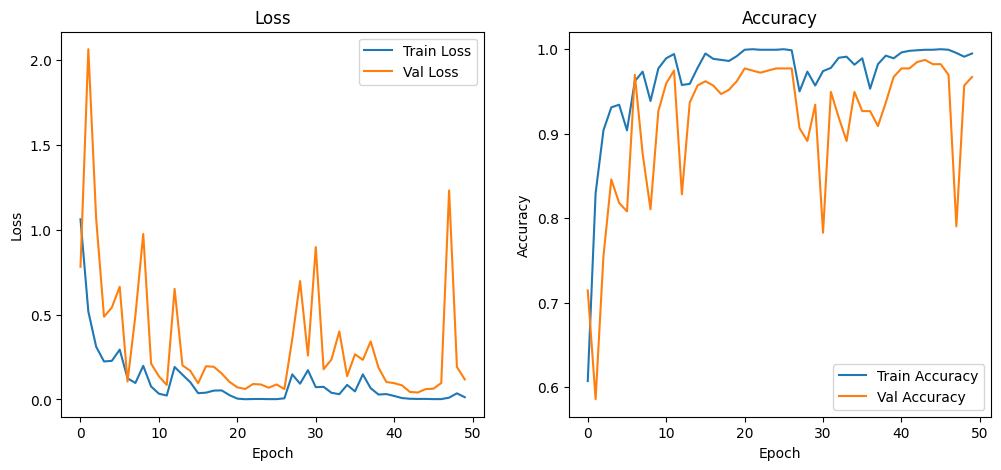

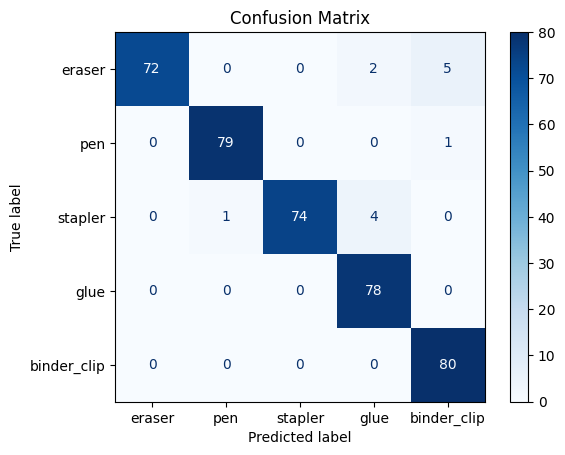

In [1]:
import os
import torch
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xml.etree import ElementTree as ET
from PIL import Image

#Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')

#Paths to dataset stored in Google Drive
data_dir = "/content/drive/My Drive/dataset"
train_images_dir = os.path.join(data_dir, "train/images")
train_annotations_dir = os.path.join(data_dir, "train/annotations")
val_images_dir = os.path.join(data_dir, "val/images")
val_annotations_dir = os.path.join(data_dir, "val/annotations")

#Define class labels
classes = ["eraser", "pen", "stapler", "glue", "binder_clip"]
class_to_idx = {c: i for i, c in enumerate(classes)}

#Custom Dataset class
class StationeryDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, transform=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(images_dir))
        self.annotation_files = sorted(os.listdir(annotations_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        #Load image
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        #Parse XML annotation
        xml_path = os.path.join(self.annotations_dir, self.annotation_files[idx])
        tree = ET.parse(xml_path)
        root = tree.getroot()
        label = root.find(".//name").text
        label_idx = class_to_idx[label]

        #Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label_idx

#Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for ResNet
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

#Load datasets
train_dataset = StationeryDataset(train_images_dir, train_annotations_dir, transform=transform)
val_dataset = StationeryDataset(val_images_dir, val_annotations_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

#Initialize ResNet-101 model
model = models.resnet101(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(classes))  # Adjust the final layer for 5 classes
model = model.to(device)

#Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Training and validation function
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        #Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation phase
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss = running_loss / total
        val_acc = correct / total

        #Log metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

#Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, epochs=50
)

#Plot Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Generate Confusion Matrix
model.eval()
all_labels, all_preds = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds, labels=range(len(classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
